In [444]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import quandl
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from dm_test import dm_test
from epftoolbox.evaluation import DM

from future import GenericFuture
from curve import CommodityCurve

In [462]:
filename = "../data/MultipleTestData.xlsx"
ir_file = "../data/InterestRates.xlsx"
data_dir = "../data/"
basis_file ="AllBasisLog.xlsx"
quandl.ApiConfig.api_key = 'Z2WYzGME3qmxnqQgBcdX'

start_date = "2000-01-01"

co_tickers = {"Brent": "ICE_B", "WTI": "CME_CL", "Wheat": "CME_W",
              "Corn": "CME_C", "Copper": "CME_HG", "Lead": "MCX_PB",
              "Aluminium": "CME_ALI", "Gas": "CME_NG", "Hogs": "CME_LN",
              "Coffee": "ICE_KC", "Cotton": "ICE_CT", "Soy":"CME_S", "Cocoa": "ICE_CC",
              "Sugar": "ICE_SB", "HeatOil": "CME_HO", "Gasoline": "CME_RB",
              "Lumber": "CME_LB", "NaturalGas": "CME_NG", "Gold": "CME_GC",
              "Platinum": "CME_PL", "AUD": "CME_AD", "ZAR": "CME_RA", "NOK": "CME_NJ",
              "CAD": "CME_CD", "UST5": "CME_FV", "UST2": "CME_TU", "UST10": "CME_TY",
              "FedFunds": "CME_FF"}

fx_co_pair = {"NOK": [co_tickers["Brent"] + "1", co_tickers["NaturalGas"]+ "1"], 
             "ZAR": [co_tickers["Gold"]+ "1"], 
             "CAD": [co_tickers["Lumber"]+ "1", co_tickers["WTI"]+ "1", co_tickers["NaturalGas"]+ "1", co_tickers["Wheat"]+ "1"], 
             "CLP": [co_tickers["Copper"]+ "1"], 
             "RUB": [co_tickers["Brent"]+ "1", co_tickers["NaturalGas"]+ "1", co_tickers["Wheat"]+ "1"], 
             "MXN": [co_tickers["WTI"]+ "1", co_tickers["Copper"]+ "1"],
             "COP": [co_tickers["WTI"]+ "1", co_tickers["Coffee"]+ "1"], 
             "AUD": [co_tickers["NaturalGas"]+ "1", co_tickers["Wheat"]+ "1",  co_tickers["Copper"]+ "1", co_tickers["Cotton"]+ "1"], 
             "BRL": [co_tickers["WTI"]+ "1", co_tickers["Soy"]+ "1", co_tickers["Coffee"]+ "1", co_tickers["Sugar"]+ "1", co_tickers["Corn"]+ "1"]}

exclude_co = []#["CME_PL1", "CME_RB1", "CME_HO1", "ICE_CC1", "ICE_SB1", "CME_CL1"]

In [463]:
fx_data = pd.read_excel("../data/FXData.xlsx")
fx_data["period"] = pd.to_datetime(fx_data["period"])
fx_data = fx_data.set_index("period")["2000-01-01":]
fx_monthly_data = fx_data.resample('M', convention="end").last()
fx_returns = fx_monthly_data.pct_change() * 12
fx_pairs = fx_returns.columns

In [464]:
raw_ust = quandl.get("USTREASURY/YIELD", start_date="2000-01-01")
ust = raw_ust
ust = ust / 100
ust_st = ust["3 MO"]
ust_st_m = ust_st.resample('M', convention="end").last()
ust_mt = ust["5 YR"]
ust_mt_m = ust_mt.resample('M', convention="end").last()
ust_lt = ust["10 YR"]
ust_lt_m = ust_lt.resample('M', convention="end").last()

In [465]:
basis = pd.read_excel(basis_file).set_index("Date").drop(columns=exclude_co)
basis_monthly = basis.resample('M', convention="end").last()
adj_basis = basis_monthly.add(ust_st_m, axis=0)
df = pd.read_excel(filename).set_index("Date")

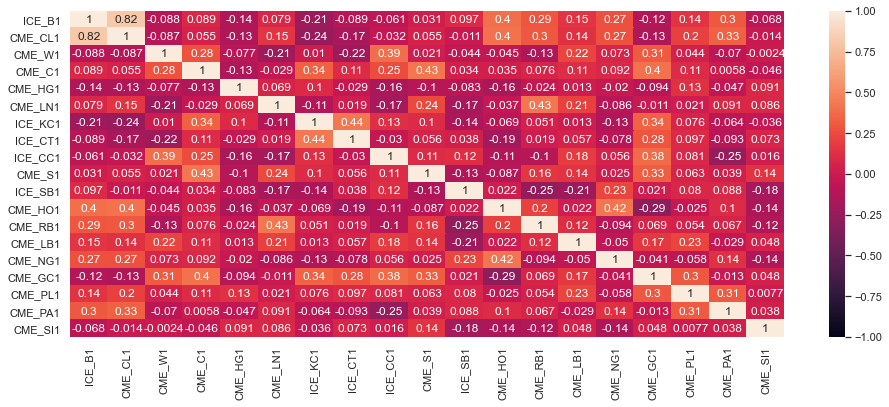

In [466]:
plt.figure(figsize=(16, 6))
sns.heatmap(basis_monthly.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

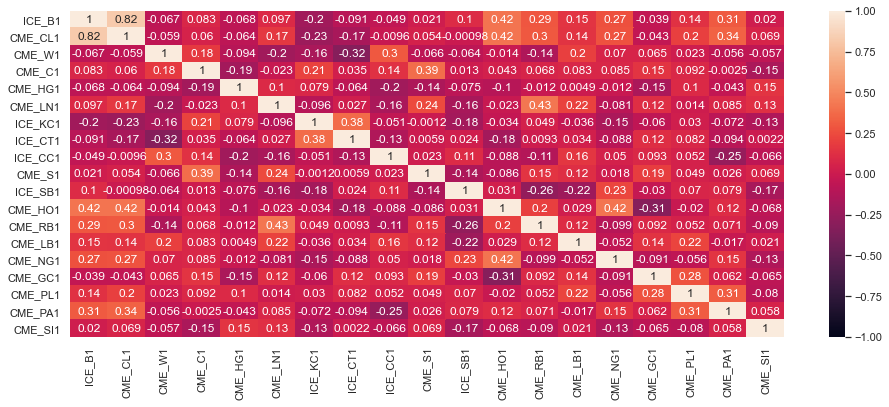

In [467]:
plt.figure(figsize=(16, 6))
adj_basis = basis_monthly.add(ust_st_m, axis=0)
sns.heatmap(adj_basis.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [468]:
ylag = fx_monthly_data["ZAR"].shift(1).dropna()
y = fx_monthly_data.loc[ylag.index, "ZAR"]
model = sm.OLS(y, ylag)
yhat = model.fit()
yhat.summary()
fx_data.head()

,AUD,BRL,CAD,CLP,COP,MXN,NOK,RUB,ZAR
period,,,,,,,,,
2000-01-01,1.575937,1.813502,1.449801,517.89,1976.72,9.618425,8.255030,28.653355,6.293535
2000-02-01,1.626004,1.770949,1.451204,503.98,1946.17,9.362055,8.318406,28.700638,6.350010
2000-03-01,1.655082,1.759552,1.452842,501.41,1951.56,9.292683,8.466974,28.629540,6.581493
2000-04-01,1.711833,1.805504,1.481233,515.61,2002.95,9.398129,8.968079,28.394056,6.848652
2000-05-01,1.746748,1.831022,1.502956,524.77,2084.92,9.506826,8.927228,28.211222,6.950016


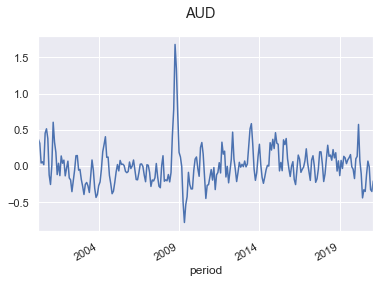

                            OLS Regression Results                            
Dep. Variable:                    AUD   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9298
Date:                Mon, 26 Apr 2021   Prob (F-statistic):              0.447
Time:                        21:04:08   Log-Likelihood:                -22.793
No. Observations:                 251   AIC:                             55.59
Df Residuals:                     246   BIC:                             73.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.033      0.509      0.6

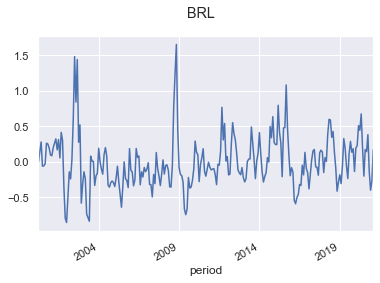

                            OLS Regression Results                            
Dep. Variable:                    BRL   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.412
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           0.000726
Time:                        21:04:08   Log-Likelihood:                -103.96
No. Observations:                 251   AIC:                             219.9
Df Residuals:                     245   BIC:                             241.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0780      0.051     -1.525      0.1

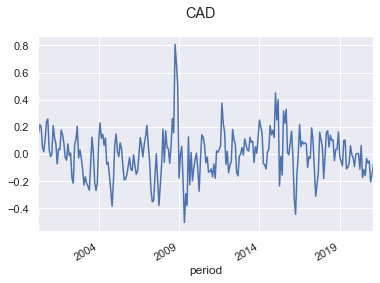

                            OLS Regression Results                            
Dep. Variable:                    CAD   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     5.176
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           0.000509
Time:                        21:04:09   Log-Likelihood:                 88.149
No. Observations:                 251   AIC:                            -166.3
Df Residuals:                     246   BIC:                            -148.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.019      1.194      0.2

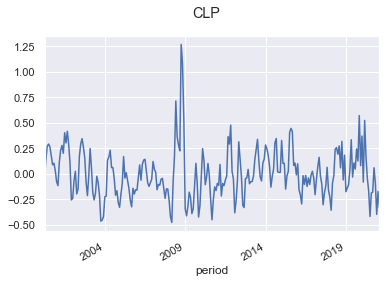

                            OLS Regression Results                            
Dep. Variable:                    CLP   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.05814
Date:                Mon, 26 Apr 2021   Prob (F-statistic):              0.810
Time:                        21:04:09   Log-Likelihood:                0.53504
No. Observations:                 251   AIC:                             2.930
Df Residuals:                     249   BIC:                             9.981
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0246      0.016      1.566      0.1

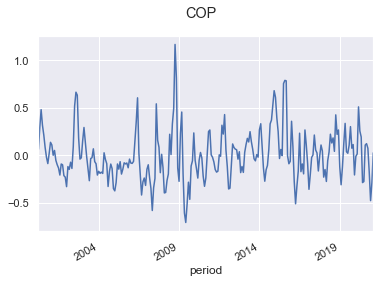

                            OLS Regression Results                            
Dep. Variable:                    COP   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     4.691
Date:                Mon, 26 Apr 2021   Prob (F-statistic):             0.0100
Time:                        21:04:09   Log-Likelihood:                -24.959
No. Observations:                 251   AIC:                             55.92
Df Residuals:                     248   BIC:                             66.49
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0644      0.040     -1.623      0.1

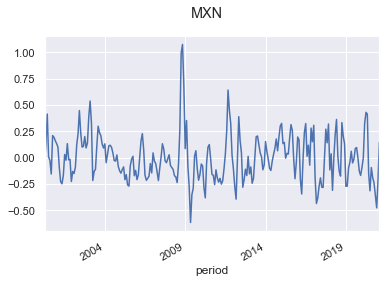

                            OLS Regression Results                            
Dep. Variable:                    MXN   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     4.465
Date:                Mon, 26 Apr 2021   Prob (F-statistic):             0.0124
Time:                        21:04:09   Log-Likelihood:                 19.766
No. Observations:                 251   AIC:                            -33.53
Df Residuals:                     248   BIC:                            -22.96
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0269      0.021      1.253      0.2

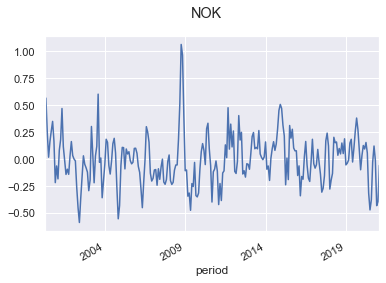

                            OLS Regression Results                            
Dep. Variable:                    NOK   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     18.35
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           3.71e-08
Time:                        21:04:10   Log-Likelihood:                 10.430
No. Observations:                 251   AIC:                            -14.86
Df Residuals:                     248   BIC:                            -4.283
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.016      1.553      0.1

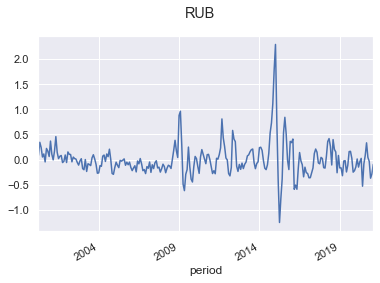

                            OLS Regression Results                            
Dep. Variable:                    RUB   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     5.472
Date:                Mon, 26 Apr 2021   Prob (F-statistic):            0.00117
Time:                        21:04:10   Log-Likelihood:                -76.622
No. Observations:                 251   AIC:                             161.2
Df Residuals:                     247   BIC:                             175.3
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1587      0.063      2.535      0.0

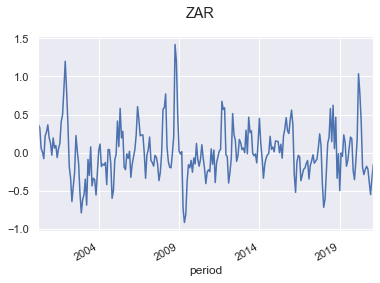

                            OLS Regression Results                            
Dep. Variable:                    ZAR   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.641
Date:                Mon, 26 Apr 2021   Prob (F-statistic):              0.201
Time:                        21:04:11   Log-Likelihood:                -87.631
No. Observations:                 251   AIC:                             179.3
Df Residuals:                     249   BIC:                             186.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0757      0.027      2.785      0.0

In [585]:
period =3
fx_returns = fx_monthly_data.pct_change(periods=period) * 12/period
fx_pairs = fx_returns.columns

for pair in fx_pairs:
    y = fx_returns[pair].dropna()
    y.head()
    X = adj_basis.loc[y.index, fx_co_pair[pair]].dropna()
    y = y.loc[X.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    if pair in ["MXN", "RUB", "COP"]:
        yhat = model.fit(cov_type='HAC', cov_kwds={'maxlags':int(np.power(X.shape[0], 1/3))})
    else:
        yhat = model.fit()
    yhat.resid.plot(subplots=True, title=pair)
    plt.show()
    print(yhat.summary())
    name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
    test = sms.het_breuschpagan(yhat.resid, yhat.model.exog)
    print(lzip(name, test))
    print("Goldfeld-Quandt")
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(yhat.resid, yhat.model.exog)
    print(lzip(name, test))



ME:  -0.006164518218508508
EV:  0.04645489108871215
MSE:  0.04649289237357847
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


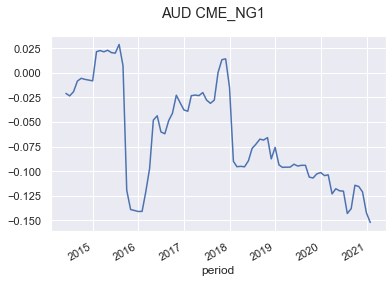

[]
[]
[]
dm_return(DM=0.8224960508165511, p_value=0.4132394856829117)
ME:  -0.022443792730010525
EV:  0.04111214291088444
MSE:  0.041615866742992114
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


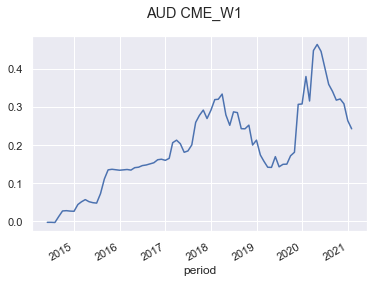

[]
[]
[]
dm_return(DM=-0.875775279550045, p_value=0.3837742068742299)
ME:  0.007153946471784302
EV:  0.040037908518977726
MSE:  0.04008908746909888
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


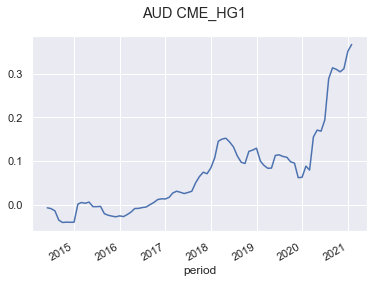

[]
[]
[]
dm_return(DM=-2.1822052424595957, p_value=0.032028068117292086)
ME:  -0.00609317960634836
EV:  0.044000825517776586
MSE:  0.04403795235549181
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


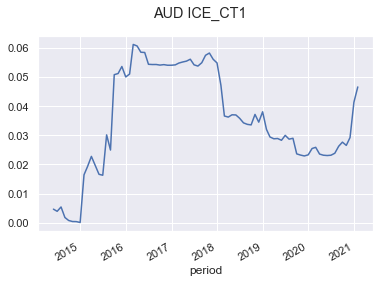

[]
[]
[]
dm_return(DM=-1.0747923416879817, p_value=0.28569868468981)
ME:  0.0017113725506558845
EV:  0.05940424545738481
MSE:  0.05940717425339195
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


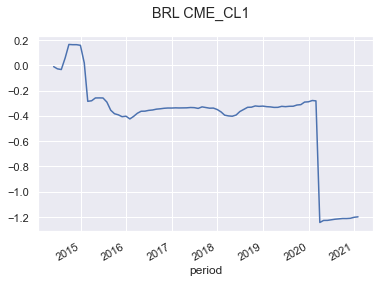

[]
[]
[]
dm_return(DM=1.1607025713231927, p_value=0.24921478643319553)
ME:  0.009075808086131742
EV:  0.045132566672187215
MSE:  0.045214936964603505
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


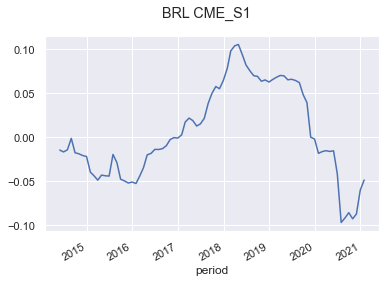

[]
[]
[]
dm_return(DM=0.4540623000524539, p_value=0.6510134873909398)
ME:  -0.01717955193450112
EV:  0.04507193857226509
MSE:  0.04536707557693531
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


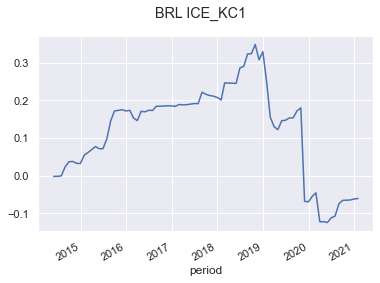

[]
[]
[]
dm_return(DM=0.19105258542119943, p_value=0.848968432470348)
ME:  -0.010816529176313368
EV:  0.04139065940624711
MSE:  0.04150765670966915
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


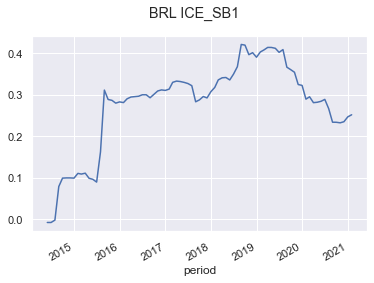

[]
[]
[]
dm_return(DM=-1.1440614483198535, p_value=0.2560098176974935)
ME:  0.0026973110909980706
EV:  0.046222713167926505
MSE:  0.046229988655048126
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


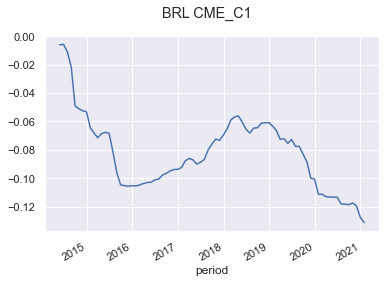

[]
[]
[]
dm_return(DM=2.821804081251399, p_value=0.006021459927388675)
ME:  -0.0057978323118815555
EV:  0.04427157612237201
MSE:  0.044305190981888704
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


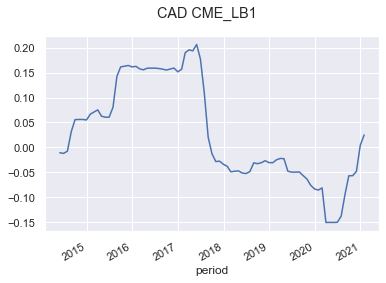

[]
[]
[]
dm_return(DM=-0.13012098091444477, p_value=0.8967973400161146)
ME:  0.0017113725506558845
EV:  0.05940424545738481
MSE:  0.05940717425339195
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


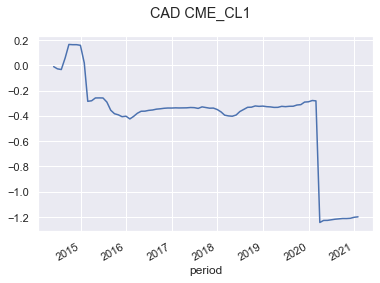

[]
[]
[]
dm_return(DM=1.1607025713231927, p_value=0.24921478643319553)
ME:  -0.006164518218508508
EV:  0.04645489108871215
MSE:  0.04649289237357847
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


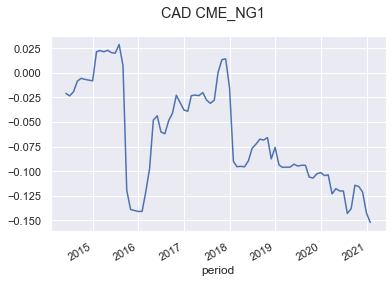

[]
[]
[]
dm_return(DM=0.8224960508165511, p_value=0.4132394856829117)
ME:  -0.022443792730010525
EV:  0.04111214291088444
MSE:  0.041615866742992114
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


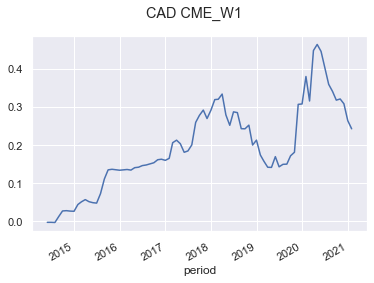

[]
[]
[]
dm_return(DM=-0.875775279550045, p_value=0.3837742068742299)
ME:  0.007153946471784302
EV:  0.040037908518977726
MSE:  0.04008908746909888
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


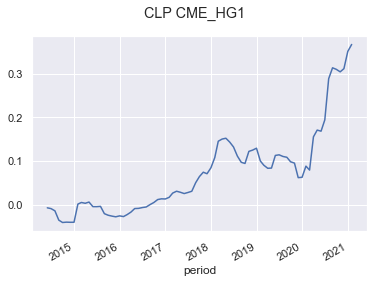

[]
[]
[]
dm_return(DM=-2.1822052424595957, p_value=0.032028068117292086)
ME:  0.0017113725506558845
EV:  0.05940424545738481
MSE:  0.05940717425339195
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


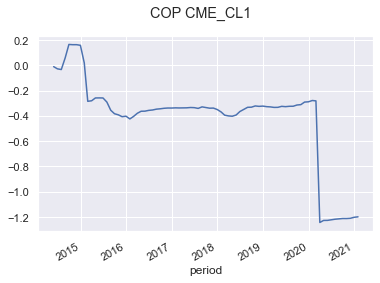

[]
[]
[]
dm_return(DM=1.1607025713231927, p_value=0.24921478643319553)
ME:  -0.01717955193450112
EV:  0.04507193857226509
MSE:  0.04536707557693531
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


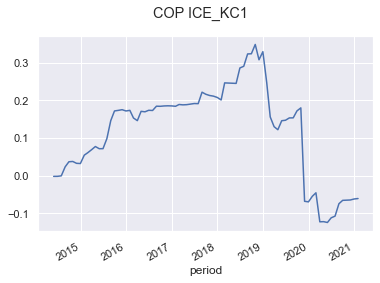

[]
[]
[]
dm_return(DM=0.19105258542119943, p_value=0.848968432470348)
ME:  0.0017113725506558845
EV:  0.05940424545738481
MSE:  0.05940717425339195
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


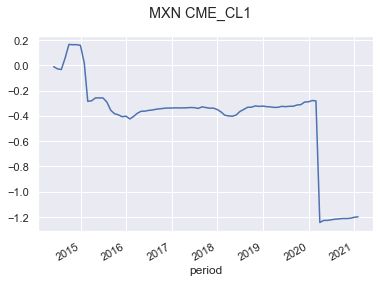

[]
[]
[]
dm_return(DM=1.1607025713231927, p_value=0.24921478643319553)
ME:  0.007153946471784302
EV:  0.040037908518977726
MSE:  0.04008908746909888
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


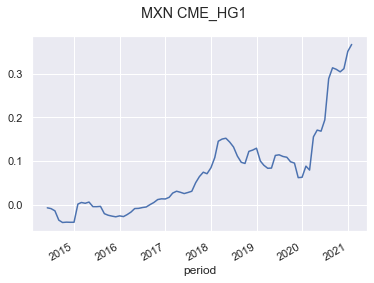

[]
[]
[]
dm_return(DM=-2.1822052424595957, p_value=0.032028068117292086)
ME:  -7.47416308723015e-05
EV:  0.04942002846013353
MSE:  0.04942003404644492
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


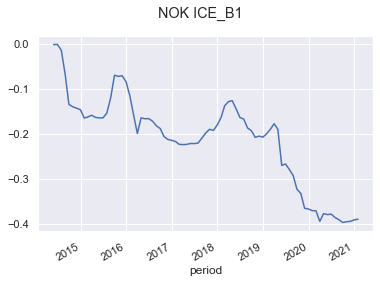

[]
[]
[]
dm_return(DM=2.251319354696925, p_value=0.02710836709056642)
ME:  -0.006164518218508508
EV:  0.04645489108871215
MSE:  0.04649289237357847
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


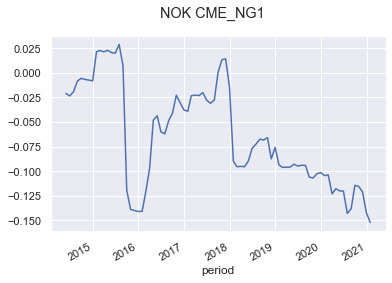

[]
[]
[]
dm_return(DM=0.8224960508165511, p_value=0.4132394856829117)
ME:  -7.47416308723015e-05
EV:  0.04942002846013353
MSE:  0.04942003404644492
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


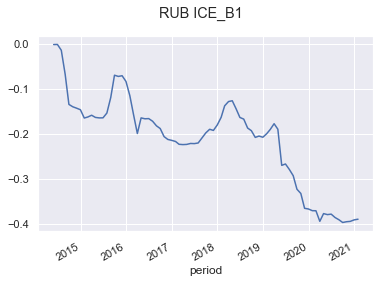

[]
[]
[]
dm_return(DM=2.251319354696925, p_value=0.02710836709056642)
ME:  -0.006164518218508508
EV:  0.04645489108871215
MSE:  0.04649289237357847
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


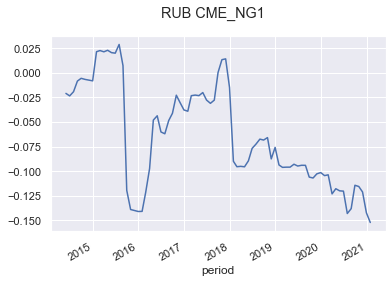

[]
[]
[]
dm_return(DM=0.8224960508165511, p_value=0.4132394856829117)
ME:  -0.022443792730010525
EV:  0.04111214291088444
MSE:  0.041615866742992114
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


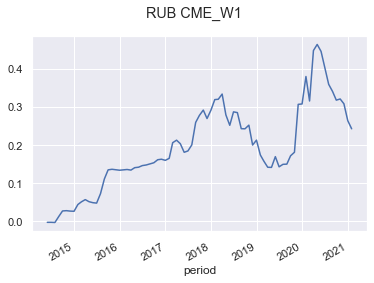

[]
[]
[]
dm_return(DM=-0.875775279550045, p_value=0.3837742068742299)
ME:  -0.009950699655776203
EV:  0.04169422319952817
MSE:  0.04179323962316763
ME (RW):  -0.003706868607042029
EV: (RW):  0.04459947528964558
MSE: (RW):  0.044613216164515454


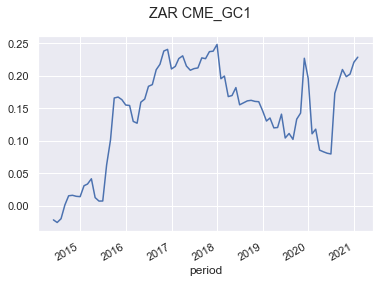

[]
[]
[]
dm_return(DM=-1.0135495631389941, p_value=0.3138533859965193)


In [586]:
window = 60
horizon = 3
for pair in fx_returns.columns:
    for ticker in fx_co_pair[pair]:
        x = fx_returns.join(adj_basis).dropna()
        predictions = pd.DataFrame(index=x.index, columns = horizon * [None])
        rw = pd.DataFrame(index=x.index, columns = horizon * [None])

        for i in range(window, x.shape[0]-horizon):
            y_sample = x.iloc[i-window:i, x.columns.get_loc(ccy)]
            y_new = x.iloc[i:i+horizon, x.columns.get_loc(ccy)]
            x_sample = x.loc[y_sample.index, ticker]
            x_new = x.loc[y_new.index, ticker]
            x_sample = sm.add_constant(x_sample)
            x_new = sm.add_constant(x_new)
            model = sm.OLS(y_sample, x_sample)
            yhat = model.fit()
            #print(yhat.summary())
            predict = yhat.predict(x_new)
            #print(y_new)
            #print("Predict")
            #print(predict)
            predictions.loc[predict.index, :] = predict.values
            rw.loc[y_new.index, :] = horizon * [y_sample.mean()]

        predictions.columns = [str(i) + "M" for i in range(1, horizon + 1)]
        rw.columns = [str(i) + "M" for i in range(1, horizon + 1)]

        predictions["Actual"] = fx_returns[ccy]
        delta_ols = predictions["Actual"] - predictions['1M']
        delta_ols = delta_ols.dropna()
        mean_error_ols = delta_ols.mean()
        error_variance_ols = ((delta_ols - mean_error_ols)*(delta_ols - mean_error_ols)).mean()
        mse_ols = (mean_error_ols * mean_error_ols) + error_variance_ols
        print("ME: ", mean_error_ols)
        print("EV: ", error_variance_ols)
        print("MSE: ", mse_ols)

        delta_rw = predictions["Actual"] - rw["1M"]
        mean_error_rw = delta_rw.mean()
        error_variance_rw = ((delta_rw - mean_error_rw)*(delta_rw - mean_error_rw)).mean()
        mse_rw = (mean_error_rw * mean_error_rw) + error_variance_rw
        print("ME (RW): ", mean_error_rw)
        print("EV: (RW): ", error_variance_rw)
        print("MSE: (RW): ", mse_rw)

        cssed = delta_rw * delta_rw - delta_ols * delta_ols
        cssed.cumsum().plot(title=pair + " " + ticker, subplots=True)
        plt.show()
        #fx_returns[ccy].plot()
        #Diebold-Mariano test

        predictions["RW1M"] = rw["1M"]
        predictions = predictions.dropna()

        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True

        print(list(filter(lambda x: not compiled_regex(str(abs(x))), predictions["Actual"].to_list())))
        print(list(filter(lambda x: not compiled_regex(str(abs(x))), predictions['1M'].to_list())))
        print(list(filter(lambda x: not compiled_regex(str(abs(x))), predictions['RW1M'].to_list())))

        try:
            rt = dm_test(predictions["Actual"], predictions['1M'], predictions["RW1M"], h = 1, crit="MSE")
            print(rt)
        except SyntaxError as se:
            print(ccy + ticker + str(se))
            pass



ME:  -0.0015754022606661409
EV:  0.058124709313812375
MSE:  0.05812719120609529
ME (RW):  0.004003838927362286
EV: (RW):  0.05697662951374216
MSE: (RW):  0.05699266023989842
[]
dm_return(DM=0.44755825794792614, p_value=0.6556968657921043)


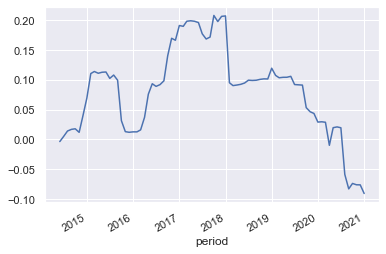

In [550]:
predictions["Actual"] = fx_returns[ccy]
delta_ols = predictions["Actual"] - predictions['1M']
delta_ols = delta_ols.dropna()
mean_error_ols = delta_ols.mean()
error_variance_ols = ((delta_ols - mean_error_ols)*(delta_ols - mean_error_ols)).mean()
mse_ols = (mean_error_ols * mean_error_ols) + error_variance_ols
print("ME: ", mean_error_ols)
print("EV: ", error_variance_ols)
print("MSE: ", mse_ols)

delta_rw = predictions["Actual"] - rw["1M"]
mean_error_rw = delta_rw.mean()
error_variance_rw = ((delta_rw - mean_error_rw)*(delta_rw - mean_error_rw)).mean()
mse_rw = (mean_error_rw * mean_error_rw) + error_variance_rw
print("ME (RW): ", mean_error_rw)
print("EV: (RW): ", error_variance_rw)
print("MSE: (RW): ", mse_rw)

cssed = delta_rw * delta_rw - delta_ols * delta_ols
cssed.cumsum().plot()
#fx_returns[ccy].plot()
#Diebold-Mariano test

predictions["RW1M"] = rw["1M"]
predictions = predictions.dropna()

print(list(filter(lambda x: str(x).isdigit(), predictions["RW1M"].to_list())))

#print(predictions)
rt = dm_test(predictions["Actual"], predictions['1M'], predictions["RW1M"], h = 1, crit="MSE")
print(rt)



In [480]:
#ARIMA 
window = 60
horizon = 2
ccy = "CLP"
tickers = fx_co_pair[ccy]

x = fx_returns.join(adj_basis).dropna()
predictions = pd.DataFrame(index=x.index, columns = horizon * [None])
arima_predictions =  pd.DataFrame(index=x.index, columns = horizon * [None])
actual = pd.DataFrame(index=x.index, columns = horizon * [None])
rw = pd.DataFrame(index=x.index, columns = horizon * [None])
ar_rw = pd.DataFrame(index=x.index, columns = horizon * [None])
fx_monthly_data_log = fx_monthly_data.transform(np.log)
x_log = fx_monthly_data_log.join(adj_basis).dropna()

for i in range(window, x.shape[0]-horizon):
    y_sample = x.iloc[i-window:i, x.columns.get_loc(ccy)]
    y_new = x.iloc[i:i+horizon, x.columns.get_loc(ccy)]
    x_sample = x.loc[y_sample.index, tickers]
    x_new = x.loc[y_new.index, tickers]
    x_sample = sm.add_constant(x_sample)
    x_new = sm.add_constant(x_new)
    model = sm.OLS(y_sample, x_sample)
    yhat = model.fit()
    #print(yhat.summary())
    predict = yhat.predict(x_new)
    predictions.loc[predict.index[0], :] = predict.values
    actual.loc[y_new.index[0], :] = y_new[0]
    rw.loc[y_new.index, :] = [0, 0]
    
    y_sample_log = x_log.iloc[i-window:i, x_log.columns.get_loc(ccy)]
    y_new_log = x_log.iloc[i:i+horizon, x_log.columns.get_loc(ccy)]
    x_sample_log = x_log.loc[y_sample_log.index, tickers]
    x_sample_log = sm.add_constant(x_sample_log)
    x_new_log = x_log.loc[y_new_log.index, tickers]
    x_new_log = sm.add_constant(x_new_log)
    arima_model = sm.tsa.SARIMAX(y_sample_log, order=(1, 1, 0), exog=x_sample_log)
    yhat_arima = arima_model.fit()
    forecast = yhat_arima.forecast(steps=horizon, exog=x_new_log)
    arima_predictions.loc[forecast.index[0], :] = forecast.values
    ar_rw.loc[y_new_log.index, :] = [y_sample_log[-1], y_sample_log[-1]]
    
predictions.columns = ["1M", "2M"]
arima_predictions.columns = ["AR1M", "AR2M"]
rw.columns = ["1M", "2M"]
ar_rw.columns = ["1M", "2M"]

C:\Users\peter.nash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\peter.nash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\peter.nash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


TypeError: cannot insert DatetimeArray with incompatible label

<AxesSubplot:xlabel='period'>

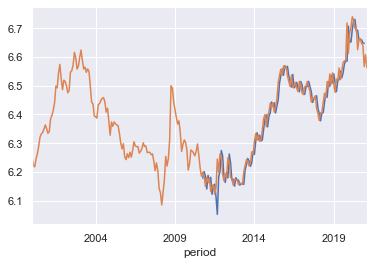

In [412]:
arima_predictions["AR1M"].plot()
fx_monthly_data_log[ccy].plot()

In [31]:
ust = raw_ust
ust = ust / 100
ust_st = ust["3 MO"]
ust_st_m = ust_st.resample('M', convention="end").last()
ust_mt = ust["5 YR"]
ust_mt_m = ust_mt.resample('M', convention="end").last()
ust_lt = ust["10 YR"]
ust_lt_m = ust_lt.resample('M', convention="end").last()


In [32]:
ust_st.resample('M', convention="end").last()

Date
2000-01-31    0.0576
2000-02-29    0.0578
2000-03-31    0.0588
2000-04-30    0.0582
2000-05-31    0.0563
               ...  
2020-12-31    0.0009
2021-01-31    0.0006
2021-02-28    0.0004
2021-03-31    0.0003
2021-04-30    0.0002
Freq: M, Name: 3 MO, Length: 256, dtype: float64

ADF Statistic: -5.057116
p-value: 0.000017
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


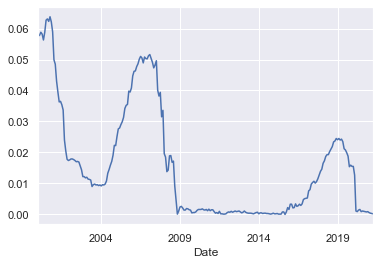

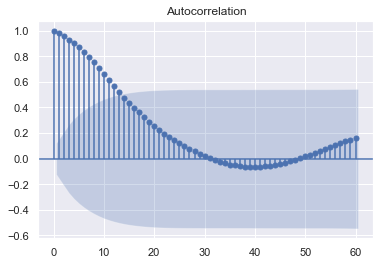

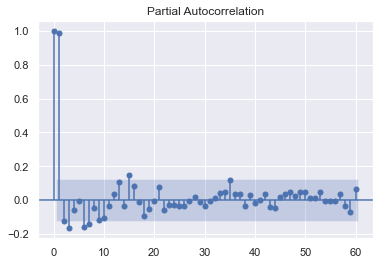

In [119]:
ust_st_m = ust_st_m.loc[monthly_basis.index]
ust_mt_m = ust_mt_m.loc[monthly_basis.index]
X = sm.add_constant(ust_st_m)
est = sm.OLS(monthly_corn_basis.values.squeeze(), X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     63.52
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           5.46e-14
Time:                        21:01:33   Log-Likelihood:                 154.79
No. Observations:                 255   AIC:                            -305.6
Df Residuals:                     253   BIC:                            -298.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0484      0.011     -4.384      0.0